In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import skimage.io as io
from PIL import Image

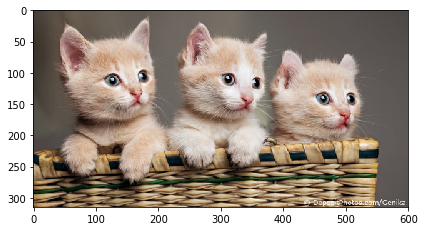

In [2]:
#numpy based raw bytes representation
cat_img  = io.imread('cat.jpg')
io.imshow(cat_img)

In [3]:
#Now let's convert the picture into it's string representation using numpy ndarray.tostring() 


cat_string = cat_img.tostring()


#Now let's convert the image back to image. To make it work correctly , you have to specify the dtype properly
reconstructed_cat_1d = np.fromstring(cat_string,dtype = np.uint8)

# Now convert it to 2d shape


reconstructed_cat_img = reconstructed_cat_1d.reshape(cat_img.shape)

#Now check whether the recons image is same as the original
np.allclose(cat_img,reconstructed_cat_img)

True

## Creating a .tfrecord file and reading it without defining a graph

In [4]:
filename_pairs = [
    ('/Users/rahulchandran/rahul/learn/machine_learning/tensorflow/helping_utils/test_img_tfrec/000000581900.jpg','/Users/rahulchandran/rahul/learn/machine_learning/tensorflow/helping_utils/test_img_tfrec/gray_000000581900.jpg'),
    ('/Users/rahulchandran/rahul/learn/machine_learning/tensorflow/helping_utils/test_img_tfrec/000000581903.jpg','/Users/rahulchandran/rahul/learn/machine_learning/tensorflow/helping_utils/test_img_tfrec/gray_000000581903.jpg'),
    ('/Users/rahulchandran/rahul/learn/machine_learning/tensorflow/helping_utils/test_img_tfrec/000000581904.jpg','/Users/rahulchandran/rahul/learn/machine_learning/tensorflow/helping_utils/test_img_tfrec/gray_000000581904.jpg'),
    ('/Users/rahulchandran/rahul/learn/machine_learning/tensorflow/helping_utils/test_img_tfrec/000000581906.jpg','/Users/rahulchandran/rahul/learn/machine_learning/tensorflow/helping_utils/test_img_tfrec/gray_000000581906.jpg'),
    ('/Users/rahulchandran/rahul/learn/machine_learning/tensorflow/helping_utils/test_img_tfrec/000000581909.jpg','/Users/rahulchandran/rahul/learn/machine_learning/tensorflow/helping_utils/test_img_tfrec/gray_000000581909.jpg'),
    ('/Users/rahulchandran/rahul/learn/machine_learning/tensorflow/helping_utils/test_img_tfrec/000000581913.jpg','/Users/rahulchandran/rahul/learn/machine_learning/tensorflow/helping_utils/test_img_tfrec/gray_000000581913.jpg'),
    ('/Users/rahulchandran/rahul/learn/machine_learning/tensorflow/helping_utils/test_img_tfrec/000000581921.jpg','/Users/rahulchandran/rahul/learn/machine_learning/tensorflow/helping_utils/test_img_tfrec/gray_000000581921.jpg'),
    ('/Users/rahulchandran/rahul/learn/machine_learning/tensorflow/helping_utils/test_img_tfrec/000000581929.jpg','/Users/rahulchandran/rahul/learn/machine_learning/tensorflow/helping_utils/test_img_tfrec/gray_000000581929.jpg')
]

In [5]:
# Writing data to a tfrecords file

def _bytes_feature(value):
    return tf.train.Feature(bytes_list = tf.train.BytesList(value=[value]))
def _int64_feature(value):
    return tf.train.Feature(int64_list = tf.train.Int64List(value=[value]))
def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

tfrecords_filename= 'test_tfrec_imgs.tfrecords'
writer = tf.python_io.TFRecordWriter(tfrecords_filename)

original_images = []

for img_path, annotation_path in filename_pairs:
    img = np.array(Image.open(img_path))
    annotation = np.array(Image.open(annotation_path))
    
    height = img.shape[0]
    width = img.shape[1]
    
    # Let's store the original images , to check in future for correctness.
    original_images.append((img,annotation))
    
    img_raw = img.tostring()
    annotation_raw = annotation.tostring()
    
    example = tf.train.Example(
        features = tf.train.Features(feature={
            'height': _int64_feature(height),
            'width':_int64_feature(width),
            'image_raw': _bytes_feature(img_raw),
            'mask_raw':_bytes_feature(annotation_raw)
        })
    )
    writer.write(example.SerializeToString())
writer.close()

In [6]:
# Now reading back and reconstruction

reconstructed_images = []
record_iterator = tf.python_io.tf_record_iterator(path=tfrecords_filename)
for string_record in record_iterator:
    example = tf.train.Example()
    example.ParseFromString(string_record)
    height = int(example.features.feature['height'].int64_list.value[0])
    width = int(example.features.feature['width'].int64_list.value[0])
    img_string = (example.features.feature['image_raw'].bytes_list.value[0])
    annotation_string = (example.features.feature['mask_raw'].bytes_list.value[0])
    
    img_1d = np.fromstring(img_string,dtype=np.uint8)
    reconstructed_img = img_1d.reshape((height,width,-1))
    annotation_1d = np.fromstring(annotation_string,dtype=np.uint8)
    reconstructed_annotation = annotation_1d.reshape((height, width))
    reconstructed_images.append((reconstructed_img, reconstructed_annotation))

In [7]:
for original_pair, reconstructed_pair in zip(original_images, reconstructed_images):
    
    img_pair_to_compare, annotation_pair_to_compare = zip(original_pair,
                                                          reconstructed_pair)
    print(np.allclose(*img_pair_to_compare))
    print(np.allclose(*annotation_pair_to_compare))

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


### Defining the graph to read and batch images from .tfrecords

In [8]:
IMAGE_HEIGHT=200
IMAGE_WIDTH = 200
def read_and_decode(filename_queue):
    reader = tf.TFRecordReader()
    _,serialized_example = reader.read(filename_queue)
    features = tf.parse_single_example(
        serialized_example,
        features = {
            'height':tf.FixedLenFeature([],tf.int64),
            'width':tf.FixedLenFeature([],tf.int64),
            'image_raw': tf.FixedLenFeature([],tf.string),
            'mask_raw': tf.FixedLenFeature([],tf.string)
        }
    )
    image = tf.decode_raw(features['image_raw'],tf.uint8)
    annotation = tf.decode_raw(features['mask_raw'],tf.uint8)
    
    height = tf.cast(features['height'], tf.int32)
    width = tf.cast(features['width'],tf.int32)
    image_shape = tf.stack([height, width, 3])
    annotation_shape = tf.stack([height, width, 1])
    
    image = tf.reshape(image,image_shape)
    annotation = tf.reshape(annotation,annotation_shape)
    image_size_const = tf.constant((IMAGE_HEIGHT, IMAGE_WIDTH, 3), dtype=tf.int32)
    annotation_size_const = tf.constant((IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=tf.int32)
    resized_image = tf.image.resize_image_with_crop_or_pad(image=image,
                                           target_height=IMAGE_HEIGHT,
                                           target_width=IMAGE_WIDTH)
    
    resized_annotation = tf.image.resize_image_with_crop_or_pad(image=annotation,
                                           target_height=IMAGE_HEIGHT,
                                           target_width=IMAGE_WIDTH)
    
    images, annotations = tf.train.shuffle_batch( [resized_image, resized_annotation],
                                                 batch_size=10,
                                                 capacity=30,
                                                 num_threads=2,
                                                 min_after_dequeue=10
                                                )
    return images, annotations

(10, 200, 200, 3)


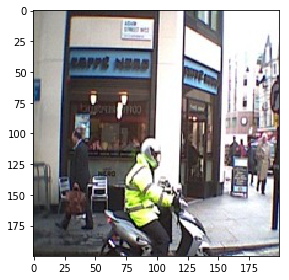

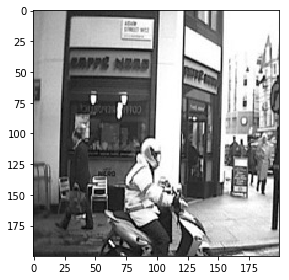

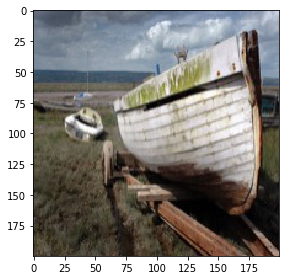

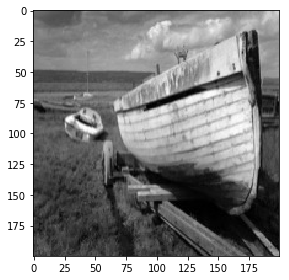

(10, 200, 200, 3)


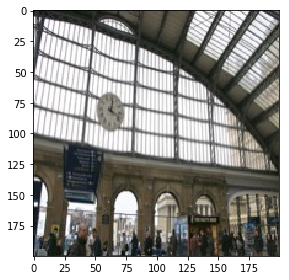

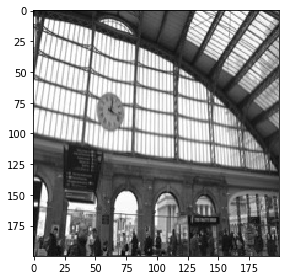

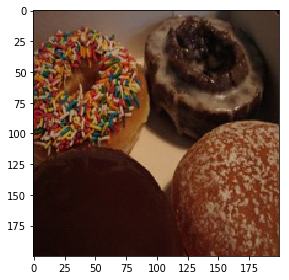

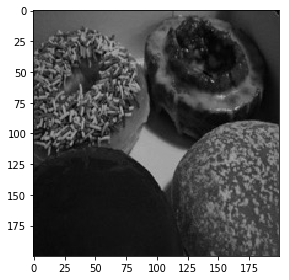

(10, 200, 200, 3)


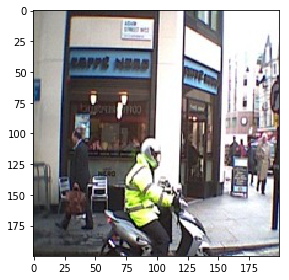

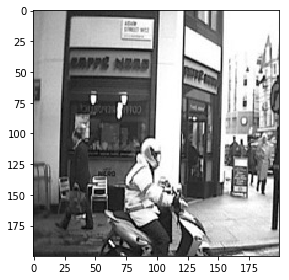

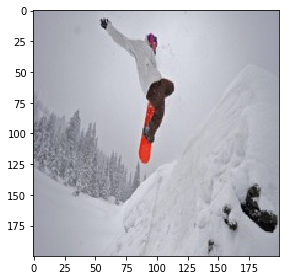

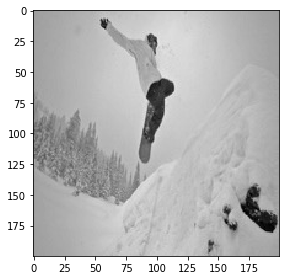

(10, 200, 200, 3)


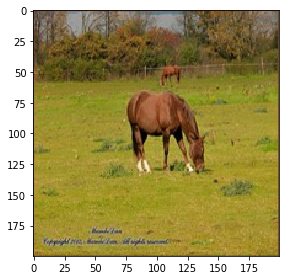

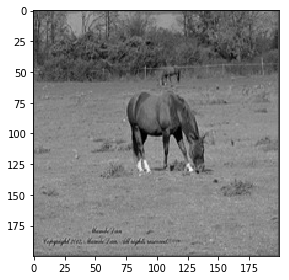

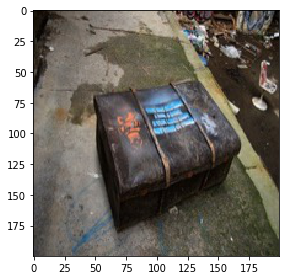

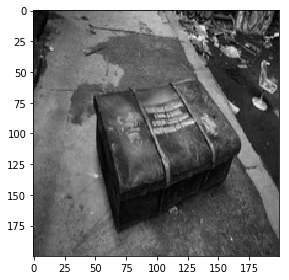

(10, 200, 200, 3)


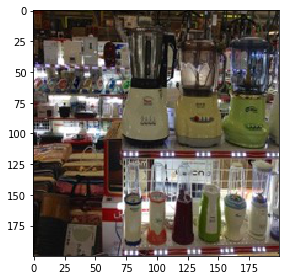

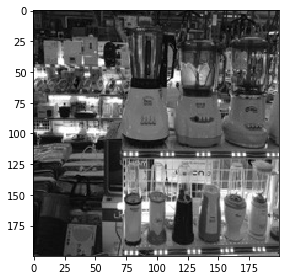

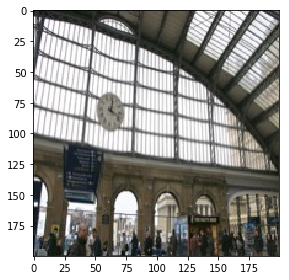

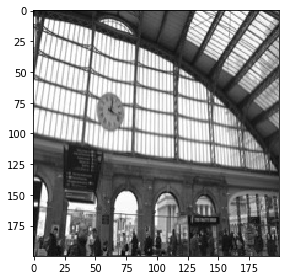

In [9]:
filename_queue = tf.train.string_input_producer([tfrecords_filename],num_epochs=10)
image,annotation = read_and_decode(filename_queue)
init_group = tf.group(tf.global_variables_initializer(),tf.local_variables_initializer())

with tf.Session() as sess:
    sess.run(init_group)
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    #Let's read 10 batches for eg
    for i in xrange(5):
        img, anno = sess.run([image, annotation])
        print img.shape
        io.imshow(img[0, :, :, :])
        io.show()
        io.imshow(anno[0, :, :, 0])
        io.show()
        io.imshow(img[1, :, :, :])
        io.show()
        io.imshow(anno[1, :, :, 0])
        io.show()
    coord.request_stop()
    coord.join(threads)